In [ ]:
#Load in necessary modules and packages.
#%pip install sounddevice
%pip install tensorflow
%pip install keras

import os
import numpy as np
import scipy.io.wavfile as sio_wav
import scipy.signal as sp_sig
from filters import (erb_point,erb_space,centre_freqs,make_erb_filters,erb_filterbank,gammatone_analysis,pow_stft,hz2mel,mel2hz,mel_fb,mel_analysis)
import matplotlib.pyplot as plt
from scipy.fftpack import dct
from signal_utils import *
%matplotlib inline
import sounddevice as sd
import scipy.io
from scipy import signal
import keras
from keras.models import model_from_json
# from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform
from helper_ops import *
import warnings
warnings.filterwarnings("ignore")
print("Done!")

In [3]:
#Main function to load the speech.
#Sarah Verhulst, Deepak Baby, Arthur Van Den Broucke, UGent, 2021

# General parameters
L = 70. # specify the desired SPL of the input

# read the wavfile
fs, x = sio_wav.read('example.wav')

# framelength_t=0.04
# frameshift_t=0.01

framelength_t = 0.025 # framelength in time = 25ms
frameshift_t = 0.01 # frameshift in time = 10ms

#cut some part out of it
sample_duration = 1 #needs to be in seconds
num_samples = int(sample_duration * fs)
x = x[:num_samples]
#adjust the SPL to the desired level
x = adjust_spl(x, L)

# parameters for gammatone analysis
fmin = 50. #minimum frequency to be analyzed
numbands = 64 #number of frequency bins

#load in CoNNear model

json_file = open("connear/Gmodel.json", "r")
loaded_model_json = json_file.read()
json_file.close()
connear = model_from_json(loaded_model_json)
connear.load_weights("connear/Gmodel.h5")
connear.summary()

# parameters for CoNNear features
fs_nn = 20e3 # CoNNear requires 20kHz

#%%
# Generate Mel feats                     ---------   MEL -----------
framelength = int(framelength_t * fs)
frameshift = int(frameshift_t * fs)
nfft = next_power_of_two(framelength)

pspec = pow_stft(x, framelength, frameshift, nfft)
mel_out = mel_analysis(x, fs, numbands, framelength, frameshift, nfft, fmin) # returns mel and cf

#Generate mfcc                         ----------- MFCC -------------
mel_feats = np.where(mel_out['mel'] == 0, np.finfo(float).eps, mel_out['mel'])  # Numerical Stability
mel_feats = 20 * np.log10(mel_feats)  # dB
numceps = 12 # number of mfcc coefficients
mfcc = dct(mel_feats, type=2, axis=1, norm='ortho')[:, 1 : (numceps + 1)]
mfcc = lifter_mfcc(mfcc)

# Generate Gammatone features           --------------- GAMMATONE -----------
gt_out = gammatone_analysis(x, fs, numbands, fmin)
gt_cochleagram = cochleagram(gt_out['bmm'], framelength, frameshift)

#Generate CoNNear features
if fs != fs_nn :
    print("Resampling signal to " + str(fs_nn) + " Hz")
    x_nn = sp_sig.resample_poly(x, fs_nn, fs)

x_nn = np.expand_dims(x_nn, axis=0) #The CoNNear model needs an (1,x,1) input, hence expanding the dimensions
x_nn = np.expand_dims(x_nn, axis=2)
nn_out = connear.predict(x_nn)
nn_out = nn_out[0,:,:]
nn_cochleagram = cochleagram(nn_out.T, int(framelength_t * fs_nn), int(frameshift_t * fs_nn))

#%%
# Plot features
plt.figure(1)
plt.plot(x), plt.title("Input Waveform")

plt.figure(2)
plt.imshow(20 * np.log10(np.flipud(pspec.T)), cmap='jet', aspect='auto')
plt.title("Power STFT in dB")
plt.xlabel("Frame Number")
plt.ylabel("Filter Number")

plt.figure(3)
plt.imshow(np.flipud(mel_feats.T), cmap='jet', aspect='auto')
plt.title("Mel Spectrogram in dB")
plt.xlabel("Frame Number")
plt.ylabel("Filter Number")

plt.figure(4)
plt.imshow(mfcc.T, cmap='jet', aspect='auto')
plt.title("MFCC coefficients")
plt.xlabel("Frame Number")
plt.ylabel("Filter Number")

plt.figure(5)
plt.imshow(20 * np.log10(gt_cochleagram), cmap='jet', aspect='auto')
plt.title("Gammatone cochleagram in dB")
plt.xlabel("Frame Number")
plt.ylabel("Filter Number")

plt.figure(6)
plt.imshow(20 * np.log10(nn_cochleagram), cmap='jet', aspect='auto')
plt.title("CoNNear cochleagram in dB - based on CoNNear framework")
plt.xlabel("Frame Number")
plt.ylabel("Filter Number")

plt.show()


NameError: name 'model_from_json' is not defined

Text(0.5, 1.0, 'Compating central frequencies')

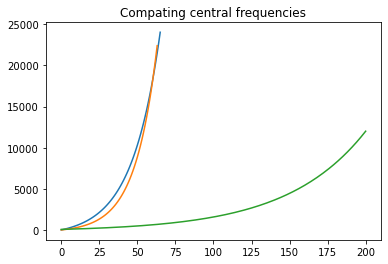

In [37]:
mel_cf = mel_out['cf']
gt_cf = np.flip(gt_out['cf'])

conn_cf = []
with open('cf.txt') as f:
    for line in f:
        conn_cf.append(float(line))
conn_cf = np.array(conn_cf) * 1000 # conn in kHz
    
plt.figure(1)
plt.plot(mel_cf)
plt.plot(gt_cf)
plt.plot(conn_cf)
plt.title("Compating central frequencies")


# What are the differences between the mel and gammatone frequency-per-band organization? 
# Are both scales logarithmically spaced?



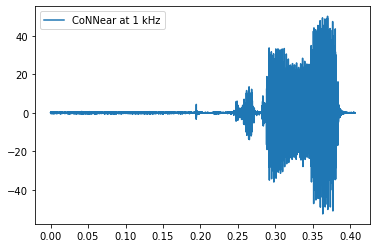

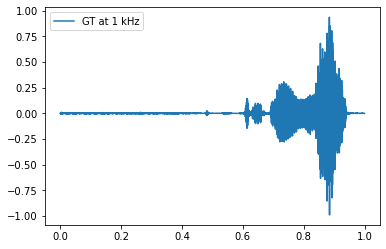

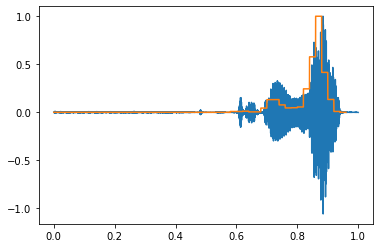

In [39]:
import sounddevice as sd #To play sound

#Get the time-domain signal output of a specific Gammatone channel
Nch,N = np.shape(gt_out['bmm'])
t = np.arange(N) / fs

#find the 1 kHz CH channel for the model
Ch1k_gt = np.abs(gt_out['cf'] - 1000).argmin()

gt = np.zeros((Nch, N)) #copy the data so we can work with it
gt = gt_out['bmm'];

N_nn,Nch_nn = np.shape(nn_out)
nn = np.zeros((Nch_nn, N_nn)) #copy the data so we can work with it
nn = nn_out;
t_nn = np.arange(N_nn) / fs

#get the 1kHz-CF time-domain signal vs energy signal in specific bins
nn_1k = nn[:,79] #time domain signal nn
gt_1k = gt[Ch1k_gt,:] #time domain signal gt
egt_1k = gt_cochleagram[Ch1k_gt,:] #gt energy in 1-kHz channel, when used as preprocessing for Machine Hearing

plt.figure()
plt.plot(t_nn,nn_1k)
plt.legend(['CoNNear at 1 kHz'])
plt.figure()
plt.plot(t,gt_1k)
plt.legend(['GT at 1 kHz'])
plt.show()

#Now generate a time domain signal from the energetic signal by extrapolating
n_repeat = int((frameshift_t *fs)) #check this framelength thin
egt_1k_time = np.repeat(egt_1k, n_repeat)
N = len(egt_1k_time)
t_egt = np.arange(N) / fs

plt.figure(7)
plt.plot(t,gt_1k/max(gt_1k))
plt.plot(t_egt,egt_1k_time/max(egt_1k_time))
#plt.xlim((0.3, 0.6))
plt.show()

#sd.play(x,fs)
sd.play(gt_1k, fs)

#sd.play(egt_1k_time, fs)




# Evaluate their influence on the energetic algorithm and sound.
# Describe your observations.


